# Mini Use Case Autoencoder 

Hier befindet sich der [Beispielcode](./miniUsecase_19_ConvAutoenc_.ipynb) für das Implementieren eines Autoencoders um ein ML-Modell zu trainieren. Dieser Code ist ähnlich aufgebaut wieder Use-Case der Support Vector Machine [(SVM)](https://github.com/TW-Robotics/AIAV/tree/devel_abdank/Support_Vector_Machine_fuer_Bildklassifizierung). Wir wollen Bildern klassifizieren. Genauer gesagt, wollen wir herausfinden welche Zahl auf einem Bild ist. 

In dem Use-Case der SVM haben wir uns auf das Modell konzentriert allerdings und besprochen wie mittels der Hauptkomponentenanalyse (PCA) dieses trainiert werden kann. Diesmal beschäftigen wir uns mit einem bisschen komplexeren Modell und werden anstatt der PCA den Autoencoder einsetzen. 

In [1]:
# Importieren der notwendigen Bibliotheken 
import numpy 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras 
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

2022-03-29 11:27:27.536553: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu/gazebo-11/plugins:/opt/ros/foxy/opt/yaml_cpp_vendor/lib:/opt/ros/foxy/opt/rviz_ogre_vendor/lib:/opt/ros/foxy/lib/x86_64-linux-gnu:/opt/ros/foxy/lib
2022-03-29 11:27:27.536577: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Daten Einlesen
Der notwendige Datensatz wird hier als CSV-Datei eingelesen. Hierzu werden 2 Datensätze benötigt, welche heruntergeladen werden müssen: </br>
Teil 1: [Trainingsset](https://pjreddie.com/media/files/mnist_train.csv)
</br>
Teil 2: [Testset](https://pjreddie.com/media/files/mnist_test.csv) 

Die Datensätze müssen anschließend in dem Ordner abgelegt werden, aus dem dieses Notebook ausgeführt wird.

In der folgenden Zelle wird der Datensatz jeweils eingelesen. Diese Teilen wir auf 5 verschiedene Variablen auf. Die Bilder sind immer die X_Variable. Dazu entsprechend ist immer ein Labels Vektor mit einem Y_ Vorgestellt. 

In [2]:
# Testbilder werden eingelesen
# Im MNIST Datensatz sind hier 10000 Bilder verfügbar 
X_test_AE  = numpy.loadtxt(open("mnist_test.csv", "rb"), delimiter=",", usecols=range(1,785), max_rows=5000)
X_test_SVM = numpy.loadtxt(open("mnist_test.csv", "rb"), delimiter=",", usecols=range(1,785), skiprows=5000)
Y_test_AE  = numpy.loadtxt(open("mnist_test.csv", "rb"), delimiter=",", usecols=range(0,1), max_rows=5000)
Y_test_SVM = numpy.loadtxt(open("mnist_test.csv", "rb"), delimiter=",", usecols=range(0,1), skiprows=5000)

# Trainingsdatenbilder werden eingelesen.
# Im MNIST Datensatz sind hier 60000 Bilder verfügbar 
# Da hier viele Fotos existieren, können wir 5 Bilder für die Evaluierung ganz am ende des Notebooks einsetzen. 
X_train_AE   = numpy.loadtxt(open("mnist_train.csv", "rb"), delimiter=",", usecols=range(1,785), max_rows=30000)
X_train_SVM  = numpy.loadtxt(open("mnist_train.csv", "rb"), delimiter=",", usecols=range(1,785), skiprows=30000, max_rows=29995)
X_evaluation = numpy.loadtxt(open("mnist_train.csv", "rb"), delimiter=",", usecols=range(1,785), skiprows=(30000+29995))
Y_train_AE   = numpy.loadtxt(open("mnist_train.csv", "rb"), delimiter=",", usecols=range(0,1),max_rows=30000)
Y_train_SVM  = numpy.loadtxt(open("mnist_train.csv", "rb"), delimiter=",", usecols=range(0,1), skiprows=30000, max_rows=29995)
Y_evaluation = numpy.loadtxt(open("mnist_train.csv", "rb"), delimiter=",", usecols=range(1,785), skiprows=(30000+29995))

In [3]:
# Die Daten werden als Zeilen-Vektor eingelesen (jede Zeile in der csv-Datei entspricht einem Bild) 
# Der Autoencoder benötigt allerdings wirkliche "Bilder"
# Daher müssen wir die 784 langen Zeilenvektoren in 28x28 Pixel große Bilder umwandeln: 

X_test_AE    = X_test_AE.reshape(-1, 28, 28)
X_test_SVM   = X_test_SVM.reshape(-1, 28, 28)
X_train_AE   = X_train_AE.reshape(-1, 28, 28)
X_train_SVM  = X_train_SVM.reshape(-1, 28, 28)
X_evaluation = X_evaluation.reshape(-1, 28, 28)
vsion_test = X_evaluation

In [4]:

# Ausgabe des Datensatzes undwie dieser aufgebaut ist: 

print("********** Dataset overview *************")
# Autoencoder Dataset 
print("Test Data Autoencoder:        {}".format( X_test_AE.shape))
print("Test Labels Autoencoder:     {}".format(  Y_test_AE.shape))
print("Train Data Autoencoder:       {}".format(X_train_AE.shape))
print("Train Labels Autoencoder:    {}".format( Y_train_AE.shape))
print("*****************************************")
# SVM Dataset 
print("Test Data SVM:        {}".format( X_test_SVM.shape))
print("Test Labels SVM:     {}".format(  Y_test_SVM.shape))
print("Train Data SVM:       {}".format(X_train_SVM.shape))
print("Train Labels SVM:    {}".format( Y_train_SVM.shape))
print("*****************************************")
#Evaluation (5 Bilder)
print("Evaluation Set:      {}".format(X_evaluation.shape))
print("*****************************************")

********** Dataset overview *************
Test Data Autoencoder:        (5000, 28, 28)
Test Labels Autoencoder:     (5000,)
Train Data Autoencoder:       (30000, 28, 28)
Train Labels Autoencoder:    (30000,)
*****************************************
Test Data SVM:        (5000, 28, 28)
Test Labels SVM:     (5000,)
Train Data SVM:       (29995, 28, 28)
Train Labels SVM:    (29995,)
*****************************************
Evaluation Set:      (5, 28, 28)
*****************************************


In [5]:
# Bevor wir die Modelle jetzt noch trainieren können, müssen wir den Datensatz Normieren. 
# Unser Eingangsbild hat Pixelwerte von 0 bis 255. Wir wollen allerdings diese Werte zwischen 0.0 und 1.0 datstellen. 

# AE
X_train_AE = X_train_AE.astype('float32') / 255.
X_test_AE=  X_test_AE.astype('float32') / 255.
# SVM
X_train_SVM = X_train_SVM.astype('float32') / 255.
X_test_SVM =  X_test_SVM.astype('float32') / 255.


## Autoencoder


Im folgenden Abschnitt wird der Autoencoder definiert. Da wir uns hier nicht mit einem zu schwierigen Use-Case befassen haben wir uns an den "standard" Autoencoder der TensorFlow-Library gehalten. Hier können wir auch über eine Variable definieren wie viele Features (bzw. wie groß der latente Raum) erhalten bleiben sollen. 
Anbei ist der Sourcecode der Implementierung von Tesorflot: [Autoencoder Source](https://www.tensorflow.org/tutorials/generative/autoencoder)

Ebenso haben wir den Aufbau in der folgenden Grafik kurz Dargestellt. Mehr Informationen dazu sind im Sotryboard enthalten.  </br>
![Aufbau](aufbau.png)

In [6]:
# Autoencoder Classe Definieren: 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [7]:
# Wir können nun die Dimensionen definieren, welche in der letzen Schicht erreicht werden soll. 
# In unserem Fall wollen wir hier nur mehr eine 7*7 große layer haben -> sprich latent_dim wird auf 49 gesetzt. 
# Mit dieser Variable können wir allerdings bestimmen wie stark die Bilder kompremiert werden sollen, bzw. wie viele Features erhalten bleiben sollen

latent_dim = 49
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

2022-03-29 11:27:41.842461: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-29 11:27:41.842936: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu/gazebo-11/plugins:/opt/ros/foxy/opt/yaml_cpp_vendor/lib:/opt/ros/foxy/opt/rviz_ogre_vendor/lib:/opt/ros/foxy/lib/x86_64-linux-gnu:/opt/ros/foxy/lib
2022-03-29 11:27:41.843033: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu/gazebo-11/plugins:/opt/ros/foxy/opt/yaml_cpp_vendor/lib:/opt/ros/foxy/opt/rviz_ogre_vend

In [8]:
# Ist der Autoencoder definiert (Zelle darüber) kann dieser mit unserem Autoencoder Datensatz trainiert werden. 
# Es werden 10 Epochen Trainiert  

autoencoder.fit(X_train_AE, X_train_AE,
                epochs=10,
                shuffle=True,
                validation_data=(X_test_AE, X_test_AE))


Epoch 1/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0381 - val_loss: 0.0204
Epoch 2/10
938/938 [==============================] - 1s 2ms/step - loss: 0.0152 - val_loss: 0.0118
Epoch 3/10
938/938 [==============================] - 1s 2ms/step - loss: 0.0097 - val_loss: 0.0086
Epoch 4/10
938/938 [==============================] - 1s 2ms/step - loss: 0.0076 - val_loss: 0.0073
Epoch 5/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 6/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0065 - val_loss: 0.0066
Epoch 7/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 8/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0062 - val_loss: 0.0064
Epoch 9/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0061 - val_loss: 0.0063
Epoch 10/10
938/938 [==============================] - 1s 2ms/step - loss: 0.0060 - val_loss: 0.0063

In [9]:
# Mit dem fertig trainierten Autoencoder können wir nun die features Abspeichern. 
# Diese verwenden wir auch gleich um die Bilder nocheinmal zu rekonstruieren. Die schauen wir uns dann später nochmal an. 
encoded_imgs = autoencoder.encoder(X_test_AE).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

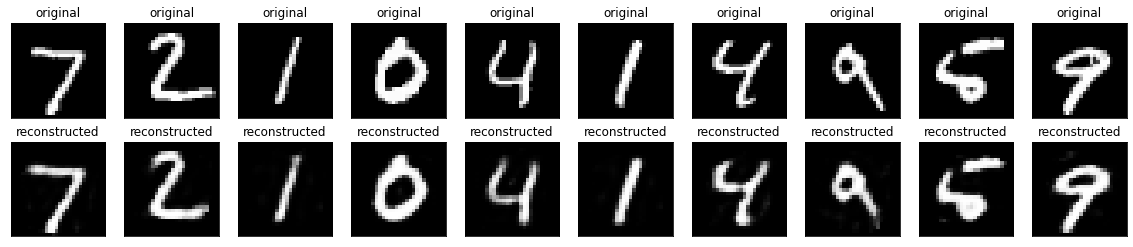

In [10]:
# Hier geben wir das "Ergebnis" des Autoencoders aus. 
# Im unten angeführten Plot werden die Originalen Bilder gezeigt und anschließend noch die vom Autoencoder rekonstruierten
# Wenn diese nicht dem Eingangsbild ähnlich schauen, dann ist etwas schief gegangen (zu kurz trainiert, zu kleiner Datensatz, zu kleine Dimensionen,...)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(X_test_AE[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## SVM
Im anschließenden Teil wird die Support Vector Machine implementiert. 
Wir werden den neuen Datensatz hernehmen. Die Features mittels dem jetzt schon trainierten Autoencoder extrahieren und anschließend für das Trianieren verwenden. 

Für genauere Informationen wie die SVM funktioniert haben wir hierzu einen eigenen Use-Case auf der AIAV-Platform: 

[Storyboard](http://www.aiav.technikum-wien.at/) </br>
[GitHub](https://github.com/TW-Robotics/AIAV/tree/devel_abdank/Support_Vector_Machine_fuer_Bildklassifizierung) </br>

In [11]:
# Importieren der beiden notwendigen Libraries für die SVM 
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [12]:
# Encoder für das reduzieren der Dimensionen.
# Hier wird der Autoencoder eimgesetzt um wie angesprochen 49 Features zu extrahieren. 

X_train = autoencoder.encoder(X_train_SVM).numpy()
X_test = autoencoder.encoder(X_test_SVM).numpy()
y_train = Y_train_SVM
y_test = Y_test_SVM


print("********** Dataset overview *************")
# Autoencoder Dataset 
print("Train Data fuer SVM Encoded:   {}".format(X_train.shape))
print("Test  Data fuer SVM Encoded:   {}".format( X_test.shape))
print("Train Labels SVM:                           {}".format( y_train.shape))
print("Test  Labels SVM:                           {}".format(  y_test.shape))
print("*****************************************")


********** Dataset overview *************
Train Data fuer SVM Encoded:   (29995, 49)
Test  Data fuer SVM Encoded:   (5000, 49)
Train Labels SVM:                           (29995,)
Test  Labels SVM:                           (5000,)
*****************************************


In [13]:
# Anschließend wird das SVM Model definiert und gleich trianiert. 
# Dieses Model ist ident zu dem angesprochenen Model des SVM Use-Cases (Genauere Details und wie dieses Funktioniert finden Sie dort)

svm = SVC(kernel='linear', probability=True, random_state=42)       # SVM Definition
svm.fit(X_train, y_train)                                           # Modell Trainieren

SVC(kernel='linear', probability=True, random_state=42)

# Evaluieren und Testen

In diesem Abschnitt versuchen wir unsere beiden Modelle zu evaluieren. Wir wissen schon aufgrund der rekonstruierten Bilder, dass unser Autoencoder wahrscheinlich die richtigen Features gelernt hat. Als nächstes wollen wir aber noch die Accuracy (also die Genauigkeit) der SVM betrachten und ebenso die beiden Modelle mit ganz neuen Bildern testen. 

In [14]:
# In dieser Zelle verwenden wir den Testdatensatz um die Accuracy der SVM zu berechnen. Diese ist bei uns 95.6%

y_pred = svm.predict(X_test)                     # Prediction für den Test Datensatz
accuracy = accuracy_score(y_test, y_pred)        # Auswertung
print('Model accuracy: ', accuracy)              # Ausgabe der Genauigkeit

Model accuracy:  0.9564


In [15]:
# In dieser Zelle Zeigen wir die 5 Bilder, welche wir am Anfang aus dem großen Datensatz getrennt haben, der SVM.
# Bevor allerdings eine Prediciton gemacht werden kann, was auf dem Bild zu sehen ist, muss der Autoencoder die Features extrahieren. 

import cv2

X_evaluation_AE  = X_evaluation.astype('float32') / 255.             # Normieren der Testbilder 
encodes_evaluation = autoencoder.encoder(X_evaluation_AE).numpy()    # Features Extrahieren mittels trainierten Autoencoder 
decoded_evaluation = autoencoder.decoder(encodes_evaluation).numpy() # Rekonstruieren der Bilder aufgrund der Features

evaluation_pred = svm.predict(encodes_evaluation)                    # Prediction/Klassifizieren was den auf den Bildern zu sehen ist. 
cv2.namedWindow("Image for prediction", 0)                           # Ausgabefenster 1 Definieren
cv2.namedWindow("Reconstructed Image", 0)                            # Ausgabefenster 1 Definieren

# Alle 5 Bilder nacheinander durch gehen 
for i in range(X_evaluation.shape[0]):
    print("Auf dem Bild ist eine {} zu sehen".format(evaluation_pred[i]))  #  Ausgabe was die SVM denkt, dass auf dem Bild ist 
                                                                           # (sollte mit Originalbild und Rekonstruiertem Bild zusammenpassen)
    cv2.imshow("Image for prediction", vsion_test[i])                      # Bild anzeigen
    cv2.imshow("Reconstructed Image", decoded_evaluation[i])               # Bild anzeigen
    cv2.waitKey(0)
    
cv2.destroyAllWindows()  #Alle geöfneten Fenster wieder Schließen


Auf dem Bild ist eine 8.0 zu sehen
Auf dem Bild ist eine 3.0 zu sehen
Auf dem Bild ist eine 5.0 zu sehen
Auf dem Bild ist eine 6.0 zu sehen
Auf dem Bild ist eine 8.0 zu sehen
